# HUMAN ACTIVITY RECOGNITION USING HIDDEN MARKOV MODELS
# Complete Implementation Notebook

# Mount Google Drive and Setup

In [21]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Mount Google Drive
drive.mount('/content/drive')

# CHANGE THIS PATH to where your data folders are located
BASE_PATH = '/content/drive/MyDrive/HMM/'  # Adjust this!
JEAN_PATH = os.path.join(BASE_PATH, 'Jean-pierre_data')
MARION_PATH = os.path.join(BASE_PATH, 'Marion_data')

print("="*70)
print("HUMAN ACTIVITY RECOGNITION USING HMM")
print("="*70)
print(f"\nData directories:")
print(f"  Jean-Pierre: {JEAN_PATH}")
print(f"  Marion: {MARION_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
HUMAN ACTIVITY RECOGNITION USING HMM

Data directories:
  Jean-Pierre: /content/drive/MyDrive/HMM/Jean-pierre_data
  Marion: /content/drive/MyDrive/HMM/Marion_data


# Data Loading Functions

In [22]:
def load_single_recording(recording_path):
    """
    Load accelerometer and gyroscope data from a single recording folder.
    Returns merged dataframe with both sensors synchronized.
    """
    try:
        acc_path = os.path.join(recording_path, 'Accelerometer.csv')
        gyro_path = os.path.join(recording_path, 'Gyroscope.csv')

        if not os.path.exists(acc_path) or not os.path.exists(gyro_path):
            return None

        acc_df = pd.read_csv(acc_path)
        gyro_df = pd.read_csv(gyro_path)

        # Handle different time column formats
        if 'seconds_elapsed' not in acc_df.columns and 'time' in acc_df.columns:
            acc_df['seconds_elapsed'] = (acc_df['time'] - acc_df['time'].iloc[0]) / 1e9
        if 'seconds_elapsed' not in gyro_df.columns and 'time' in gyro_df.columns:
            gyro_df['seconds_elapsed'] = (gyro_df['time'] - gyro_df['time'].iloc[0]) / 1e9

        # Rename columns for clarity
        acc_df = acc_df.rename(columns={'x': 'x_acc', 'y': 'y_acc', 'z': 'z_acc'})
        gyro_df = gyro_df.rename(columns={'x': 'x_gyro', 'y': 'y_gyro', 'z': 'z_gyro'})

        # Merge accelerometer and gyroscope data
        merged = pd.merge_asof(
            acc_df.sort_values('seconds_elapsed')[['seconds_elapsed', 'x_acc', 'y_acc', 'z_acc']],
            gyro_df.sort_values('seconds_elapsed')[['seconds_elapsed', 'x_gyro', 'y_gyro', 'z_gyro']],
            on='seconds_elapsed',
            direction='nearest'
        )

        return merged

    except Exception as e:
        print(f"    Error: {str(e)}")
        return None


def load_activity_data(base_path, activity, participant_name):
    """Load all recordings for a specific activity and participant"""
    activity_path = os.path.join(base_path, activity)

    if not os.path.exists(activity_path):
        print(f"  ⚠️ Activity folder not found: {activity}")
        return None

    subfolders = sorted([f for f in os.listdir(activity_path)
                        if os.path.isdir(os.path.join(activity_path, f))])

    all_recordings = []
    print(f"\n  Loading {activity} for {participant_name}:")

    for subfolder in subfolders:
        recording_path = os.path.join(activity_path, subfolder)
        merged_data = load_single_recording(recording_path)

        if merged_data is not None and len(merged_data) > 0:
            merged_data['participant'] = participant_name
            merged_data['activity'] = activity
            merged_data['recording_id'] = f"{participant_name}_{activity}_{subfolder}"
            all_recordings.append(merged_data)
            print(f"    ✓ {subfolder}: {len(merged_data)} samples")

    if all_recordings:
        combined = pd.concat(all_recordings, ignore_index=True)
        print(f"    Total: {len(combined)} samples from {len(all_recordings)} recordings")
        return combined
    return None

# Load All Data for Both Participants

In [23]:
print("\n" + "="*70)
print("STEP 1: DATA LOADING")
print("="*70)

activities = ['walking', 'standing', 'jumping', 'still']
all_data = []

# Load Jean-Pierre's data
print("\n📱 Jean-Pierre's Data:")
for activity in activities:
    data = load_activity_data(JEAN_PATH, activity, 'Jean-Pierre')
    if data is not None:
        all_data.append(data)

# Load Marion's data
print("\n📱 Marion's Data:")
for activity in activities:
    data = load_activity_data(MARION_PATH, activity, 'Marion')
    if data is not None:
        all_data.append(data)

# Combine all data
complete_dataset = pd.concat(all_data, ignore_index=True)

print("\n" + "="*70)
print("DATA LOADING SUMMARY")
print("="*70)
print(f"Total samples collected: {len(complete_dataset):,}")
print(f"\nSamples per activity:")
for activity, count in complete_dataset.groupby('activity').size().items():
    print(f"  {activity.capitalize():<12}: {count:>6,} samples")
print(f"\nTotal recordings: {complete_dataset['recording_id'].nunique()}")
print(f"Participants: {', '.join(complete_dataset['participant'].unique())}")


STEP 1: DATA LOADING

📱 Jean-Pierre's Data:

  Loading walking for Jean-Pierre:
    ✓ walking_1: 974 samples
    ✓ walking_10: 788 samples
    ✓ walking_2: 761 samples
    ✓ walking_3: 793 samples
    ✓ walking_4: 779 samples
    ✓ walking_5: 858 samples
    ✓ walking_6: 839 samples
    ✓ walking_7: 824 samples
    ✓ walking_8: 799 samples
    ✓ walking_9: 855 samples
    Total: 8270 samples from 10 recordings

  Loading standing for Jean-Pierre:
    ✓ standing_1: 1069 samples
    ✓ standing_10: 1030 samples
    ✓ standing_2: 1093 samples
    ✓ standing_3: 1071 samples
    ✓ standing_4: 985 samples
    ✓ standing_5: 1082 samples
    ✓ standing_6: 1098 samples
    ✓ standing_7: 1052 samples
    ✓ standing_8: 1097 samples
    ✓ standing_9: 1048 samples
    Total: 10625 samples from 10 recordings

  Loading jumping for Jean-Pierre:
    ✓ jumping_1: 885 samples
    ✓ jumping_10: 767 samples
    ✓ jumping_2: 856 samples
    ✓ jumping_3: 790 samples
    ✓ jumping_4: 947 samples
    ✓ jumpin

# Sampling Rate Analysis

In [24]:
print("\n" + "="*70)
print("STEP 2: SAMPLING RATE ANALYSIS")
print("="*70)

def calculate_sampling_rate(df):
    """Calculate sampling rate from time differences"""
    time_diffs = df['seconds_elapsed'].diff().dropna()
    median_interval = time_diffs.median()
    return 1 / median_interval if median_interval > 0 else 0

sampling_info = []
for participant in complete_dataset['participant'].unique():
    for activity in complete_dataset['activity'].unique():
        subset = complete_dataset[
            (complete_dataset['participant'] == participant) &
            (complete_dataset['activity'] == activity)
        ]
        if len(subset) > 1:
            rate = calculate_sampling_rate(subset)
            sampling_info.append({
                'Participant': participant,
                'Activity': activity.capitalize(),
                'Sampling_Rate_Hz': round(rate, 1)
            })

sampling_df = pd.DataFrame(sampling_info)
print("\nDetected Sampling Rates:")
print(sampling_df.pivot(index='Participant', columns='Activity', values='Sampling_Rate_Hz'))

avg_rate = sampling_df['Sampling_Rate_Hz'].mean()
print(f"\n📊 Average sampling rate: {avg_rate:.1f} Hz")
print(f"   Rate variation: {sampling_df['Sampling_Rate_Hz'].std():.2f} Hz")


STEP 2: SAMPLING RATE ANALYSIS

Detected Sampling Rates:
Activity     Jumping  Standing  Still  Walking
Participant                                   
Jean-Pierre     98.7      98.7   98.7     98.7
Marion         100.5     100.5  100.5    100.5

📊 Average sampling rate: 99.6 Hz
   Rate variation: 0.96 Hz


# Harmonize Sampling Rates

In [25]:
print("\n" + "="*70)
print("STEP 3: SAMPLING RATE HARMONIZATION")
print("="*70)

TARGET_RATE = 100  # Hz

print(f"\n🔄 Resampling all data to {TARGET_RATE} Hz using linear interpolation")
print("   Justification: Ensures consistent time windows across all recordings")

def resample_to_target(df, target_rate=100):
    """Resample recording to target sampling rate"""
    if len(df) < 2:
        return df

    start_time = df['seconds_elapsed'].min()
    end_time = df['seconds_elapsed'].max()
    duration = end_time - start_time
    n_samples = int(duration * target_rate)

    new_times = np.linspace(start_time, end_time, n_samples)
    resampled = pd.DataFrame({'seconds_elapsed': new_times})

    for col in ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro']:
        resampled[col] = np.interp(new_times, df['seconds_elapsed'], df[col])

    for col in ['participant', 'activity', 'recording_id']:
        resampled[col] = df[col].iloc[0]

    return resampled

resampled_data = []
for recording_id in complete_dataset['recording_id'].unique():
    recording = complete_dataset[complete_dataset['recording_id'] == recording_id]
    resampled = resample_to_target(recording, TARGET_RATE)
    resampled_data.append(resampled)

harmonized_dataset = pd.concat(resampled_data, ignore_index=True)

print(f"\n✅ Resampling complete!")
print(f"   Before: {len(complete_dataset):,} samples")
print(f"   After:  {len(harmonized_dataset):,} samples")

# Save harmonized dataset
harmonized_dataset.to_csv('Harmonized_Dataset.csv', index=False)
print(f"\n💾 Saved: Harmonized_Dataset.csv")


STEP 3: SAMPLING RATE HARMONIZATION

🔄 Resampling all data to 100 Hz using linear interpolation
   Justification: Ensures consistent time windows across all recordings

✅ Resampling complete!
   Before: 67,062 samples
   After:  67,405 samples

💾 Saved: Harmonized_Dataset.csv


# Data Quality Visualization


STEP 4: DATA QUALITY VISUALIZATION

Generating sensor data visualizations...


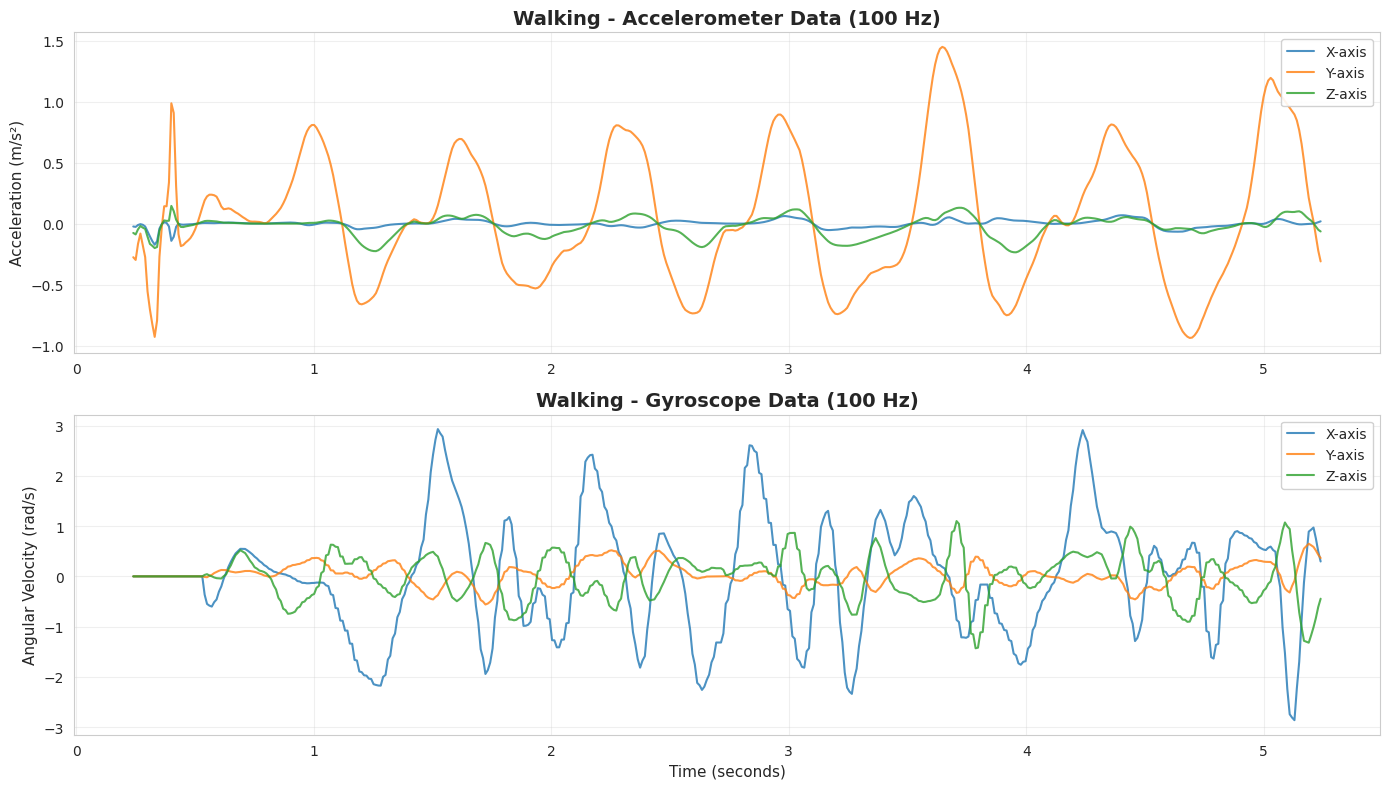

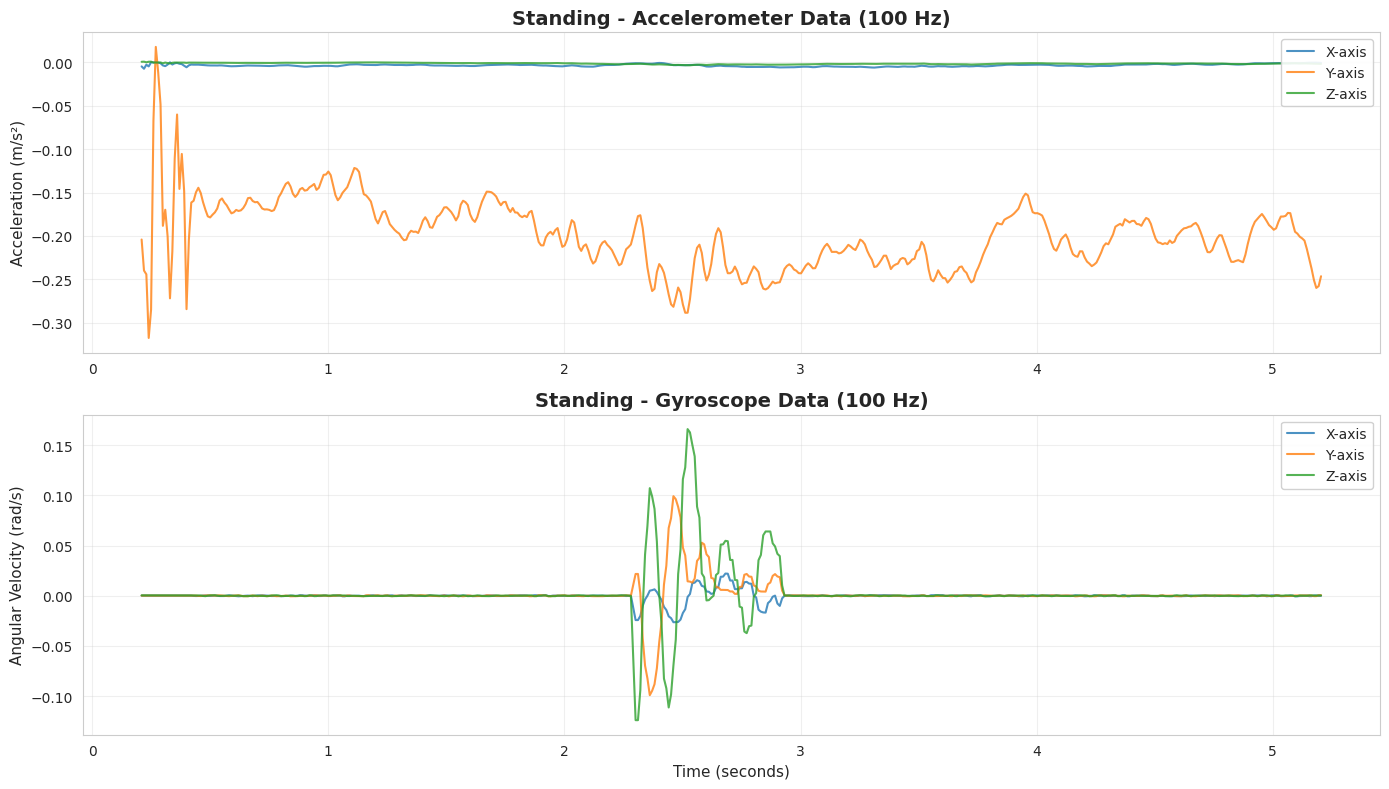

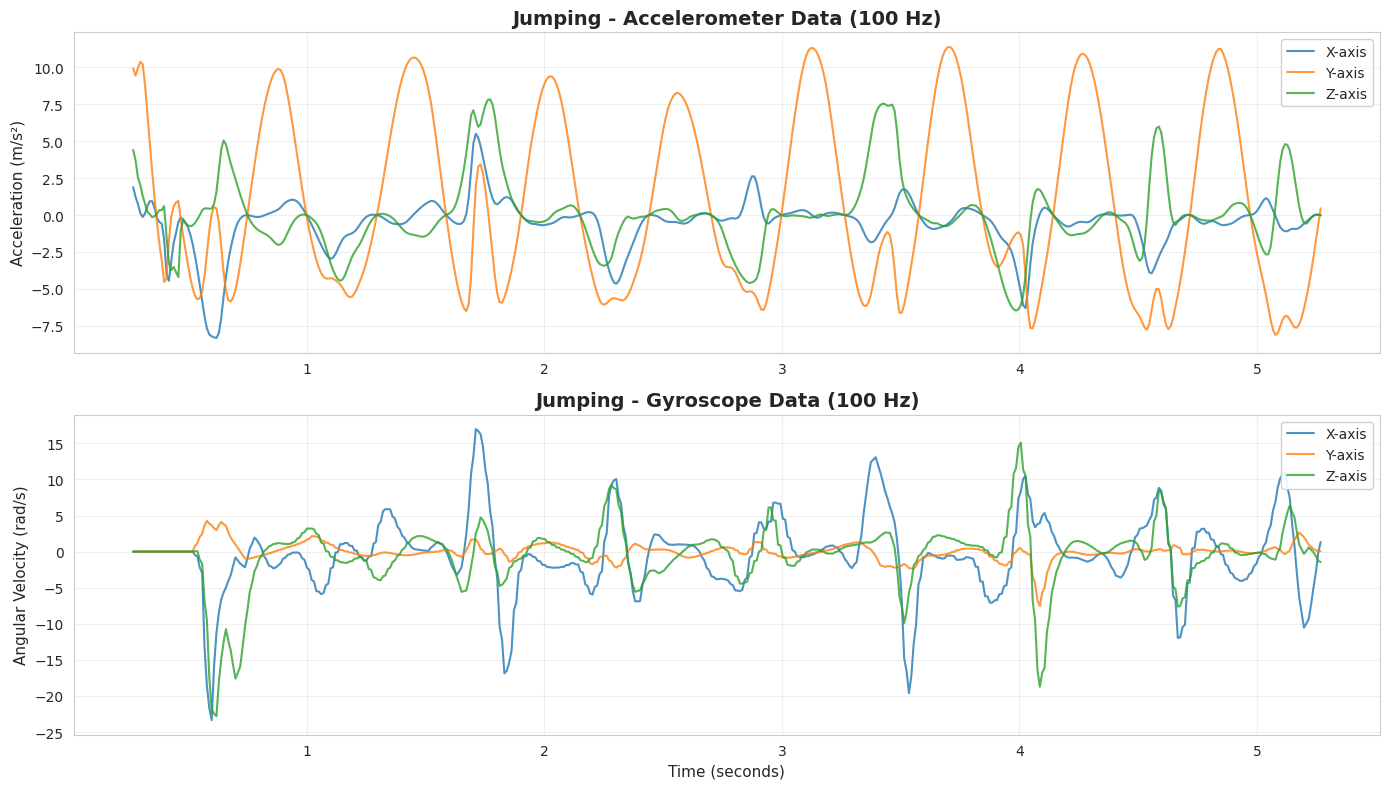

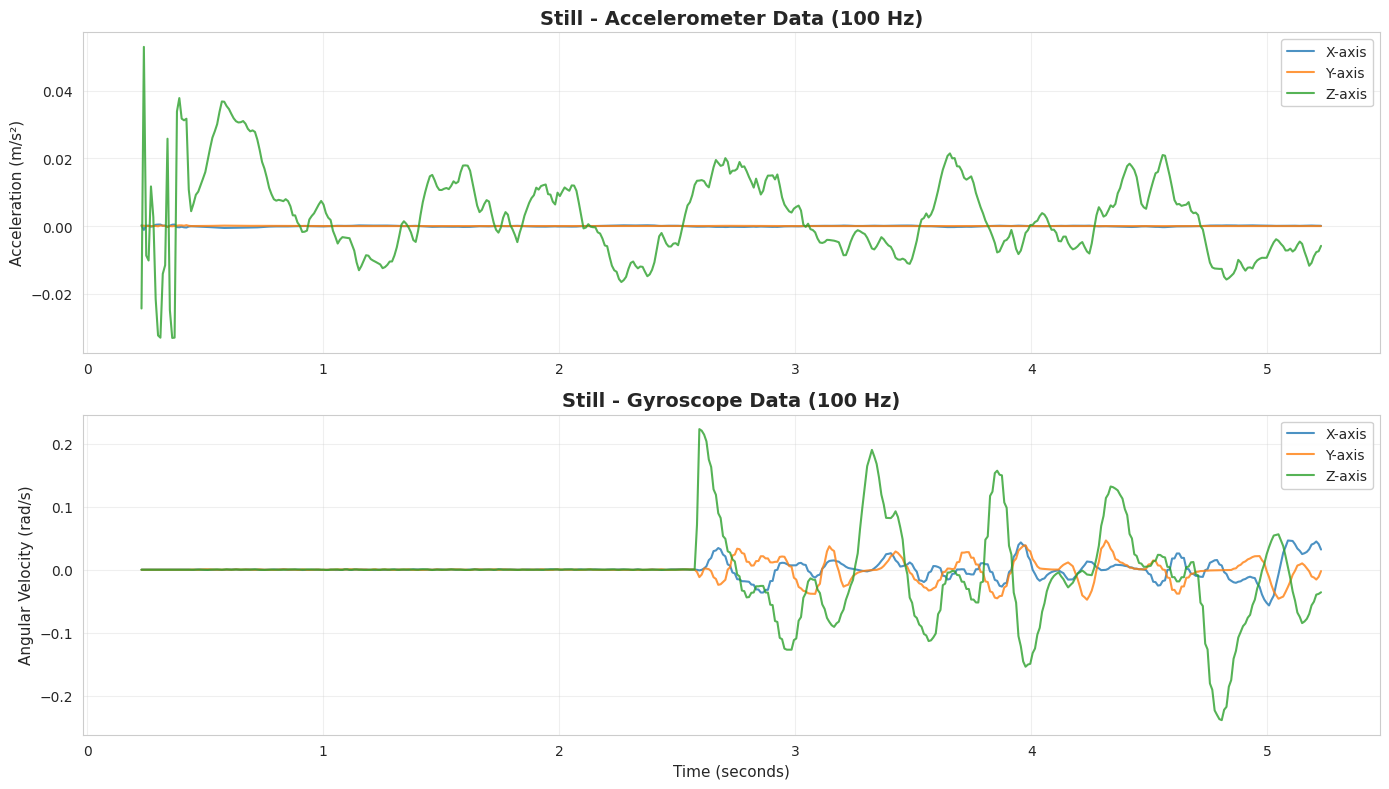


✅ Visualizations saved for report


In [26]:
print("\n" + "="*70)
print("STEP 4: DATA QUALITY VISUALIZATION")
print("="*70)

def plot_activity_sensors(df, activity, max_samples=500):
    """Visualize accelerometer and gyroscope for an activity"""
    data = df[df['activity'] == activity].head(max_samples)

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Accelerometer
    axes[0].plot(data['seconds_elapsed'], data['x_acc'], label='X-axis', alpha=0.8, lw=1.5)
    axes[0].plot(data['seconds_elapsed'], data['y_acc'], label='Y-axis', alpha=0.8, lw=1.5)
    axes[0].plot(data['seconds_elapsed'], data['z_acc'], label='Z-axis', alpha=0.8, lw=1.5)
    axes[0].set_title(f'{activity.capitalize()} - Accelerometer Data (100 Hz)',
                     fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
    axes[0].legend(loc='upper right', framealpha=0.9)
    axes[0].grid(True, alpha=0.3)

    # Gyroscope
    axes[1].plot(data['seconds_elapsed'], data['x_gyro'], label='X-axis', alpha=0.8, lw=1.5)
    axes[1].plot(data['seconds_elapsed'], data['y_gyro'], label='Y-axis', alpha=0.8, lw=1.5)
    axes[1].plot(data['seconds_elapsed'], data['z_gyro'], label='Z-axis', alpha=0.8, lw=1.5)
    axes[1].set_title(f'{activity.capitalize()} - Gyroscope Data (100 Hz)',
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time (seconds)', fontsize=11)
    axes[1].set_ylabel('Angular Velocity (rad/s)', fontsize=11)
    axes[1].legend(loc='upper right', framealpha=0.9)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'visualization_{activity}.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nGenerating sensor data visualizations...")
for activity in ['walking', 'standing', 'jumping', 'still']:
    plot_activity_sensors(harmonized_dataset, activity)

print("\n✅ Visualizations saved for report")


# Feature Extraction - Time Domain

In [27]:
print("\n" + "="*70)
print("STEP 5: FEATURE EXTRACTION")
print("="*70)

WINDOW_SEC = 2
STEP_SEC = 1
SAMPLING_RATE = 100

print(f"\n⚙️  Window Configuration:")
print(f"   Window size: {WINDOW_SEC} seconds ({WINDOW_SEC * SAMPLING_RATE} samples)")
print(f"   Step size: {STEP_SEC} second ({STEP_SEC * SAMPLING_RATE} samples)")
print(f"   Overlap: 50%")
print(f"\n   Justification:")
print(f"   • 2-second window captures 1-2 complete motion cycles")
print(f"   • At 100Hz, 200 samples ensure statistical reliability")
print(f"   • 50% overlap provides good temporal resolution")

def extract_time_features(df, window_sec=2, step_sec=1, sampling_rate=100):
    """
    Extract time-domain features from windowed sensor data.

    Features justify why they distinguish activities:
    - Mean/Std: Captures activity intensity and variability
    - RMS: Overall motion energy (high for jumping, low for standing)
    - SMA: Total movement magnitude across all axes
    - Correlation: Pattern consistency between axes
    """
    window_size = window_sec * sampling_rate
    step_size = step_sec * sampling_rate
    features_list = []

    for (activity, recording_id), group in df.groupby(['activity', 'recording_id']):
        group = group.sort_values('seconds_elapsed').reset_index(drop=True)

        for start in range(0, len(group) - window_size, step_size):
            end = start + window_size
            window = group.iloc[start:end]

            features = {
                # Accelerometer features
                'mean_x_acc': window['x_acc'].mean(),
                'std_x_acc': window['x_acc'].std(),
                'mean_y_acc': window['y_acc'].mean(),
                'std_y_acc': window['y_acc'].std(),
                'mean_z_acc': window['z_acc'].mean(),
                'std_z_acc': window['z_acc'].std(),
                'rms_acc': np.sqrt(np.mean(window['x_acc']**2 + window['y_acc']**2 + window['z_acc']**2)),
                'SMA_acc': (window[['x_acc', 'y_acc', 'z_acc']].abs().sum().sum()) / len(window),

                # Gyroscope features
                'mean_x_gyro': window['x_gyro'].mean(),
                'std_x_gyro': window['x_gyro'].std(),
                'mean_y_gyro': window['y_gyro'].mean(),
                'std_y_gyro': window['y_gyro'].std(),
                'mean_z_gyro': window['z_gyro'].mean(),
                'std_z_gyro': window['z_gyro'].std(),

                # Cross-axis features
                'corr_xy_acc': window['x_acc'].corr(window['y_acc']),
                'mag_mean_acc': np.sqrt(window['x_acc']**2 + window['y_acc']**2 + window['z_acc']**2).mean(),
                'mag_std_acc': np.sqrt(window['x_acc']**2 + window['y_acc']**2 + window['z_acc']**2).std(),

                # Metadata
                'activity': activity,
                'participant': window['participant'].iloc[0],
                'recording_id': recording_id
            }
            features_list.append(features)

    return pd.DataFrame(features_list)

print("\n⏳ Extracting time-domain features...")
features_time = extract_time_features(harmonized_dataset)
print(f"✅ Extracted {len(features_time)} feature windows")
print(f"\n   Time-domain features: 17 features")
print(f"   - Accelerometer: mean (3), std (3), RMS (1), SMA (1)")
print(f"   - Gyroscope: mean (3), std (3)")
print(f"   - Cross-features: correlation (1), magnitude stats (2)")


STEP 5: FEATURE EXTRACTION

⚙️  Window Configuration:
   Window size: 2 seconds (200 samples)
   Step size: 1 second (100 samples)
   Overlap: 50%

   Justification:
   • 2-second window captures 1-2 complete motion cycles
   • At 100Hz, 200 samples ensure statistical reliability
   • 50% overlap provides good temporal resolution

⏳ Extracting time-domain features...
✅ Extracted 555 feature windows

   Time-domain features: 17 features
   - Accelerometer: mean (3), std (3), RMS (1), SMA (1)
   - Gyroscope: mean (3), std (3)
   - Cross-features: correlation (1), magnitude stats (2)


# Feature Extraction - Frequency Domain

In [32]:
def extract_frequency_features(df, window_sec=2, step_sec=1, sampling_rate=100):
    """
    Extract frequency-domain features using FFT.

    Features justify activity distinction:
    - Dominant frequency: Identifies repetitive patterns (walking stride ~2Hz, jumping ~1.5Hz)
    - Spectral energy: Total motion intensity in frequency domain
    - Spectral entropy: Motion regularity (low for periodic activities, high for random)
    """
    window_size = window_sec * sampling_rate
    step_size = step_sec * sampling_rate
    freq_features_list = []

    for (activity, recording_id), group in df.groupby(['activity', 'recording_id']):
        group = group.sort_values('seconds_elapsed').reset_index(drop=True)

        for start in range(0, len(group) - window_size, step_size):
            end = start + window_size
            window = group.iloc[start:end]

            # Compute accelerometer magnitude
            acc_mag = np.sqrt(window['x_acc']**2 + window['y_acc']**2 + window['z_acc']**2)

            # Apply FFT
            fft_vals = np.abs(fft(acc_mag.values))
            freqs = fftfreq(len(acc_mag), 1/sampling_rate)

            # Positive frequencies only
            pos_mask = freqs > 0
            fft_vals = fft_vals[pos_mask]
            freqs = freqs[pos_mask]

            # Normalize for entropy calculation
            fft_norm = fft_vals / (np.sum(fft_vals) + 1e-10)

            freq_features = {
                'dominant_freq': freqs[np.argmax(fft_vals)],
                'spectral_energy': np.sum(fft_vals**2),
                'spectral_entropy': -np.sum(fft_norm * np.log2(fft_norm + 1e-10))
            }
            # Add metadata here, so it aligns with time features
            freq_features['activity'] = activity
            freq_features['recording_id'] = recording_id

            freq_features_list.append(freq_features)


    return pd.DataFrame(freq_features_list)

print("\n⏳ Extracting frequency-domain features...")
features_freq = extract_frequency_features(harmonized_dataset)
print(f"✅ Extracted {len(features_freq)} frequency feature windows")
print(f"\n   Frequency-domain features: 3 features")
print(f"   - Dominant frequency (identifies periodic patterns)")
print(f"   - Spectral energy (overall frequency intensity)")
print(f"   - Spectral entropy (motion regularity measure)")

# Merge all features using concat as suggested
# Ensure columns are in the same order or concat will align by column names
# Drop redundant columns from features_freq before concatenating
features_complete = pd.concat([features_time, features_freq.drop(['activity', 'recording_id'], axis=1)], axis=1)


print(f"\n✅ Complete feature set: {features_complete.shape}")
print(f"   Total features: {features_complete.shape[1] - 2} (17 time + 3 frequency, excluding activity/recording_id)")
print(f"\n   Samples per activity:")
for activity, count in features_complete['activity'].value_counts().items():
    print(f"   {activity.capitalize():<12}: {count:>4} windows")

features_complete.to_csv('Complete_Features.csv', index=False)
print(f"\n💾 Saved: Complete_Features.csv")


⏳ Extracting frequency-domain features...
✅ Extracted 555 frequency feature windows

   Frequency-domain features: 3 features
   - Dominant frequency (identifies periodic patterns)
   - Spectral energy (overall frequency intensity)
   - Spectral entropy (motion regularity measure)

✅ Complete feature set: (555, 23)
   Total features: 21 (17 time + 3 frequency, excluding activity/recording_id)

   Samples per activity:
   Standing    :  158 windows
   Jumping     :  135 windows
   Walking     :  133 windows
   Still       :  129 windows

💾 Saved: Complete_Features.csv


# Feature Normalization

In [33]:
print("\n" + "="*70)
print("STEP 6: FEATURE NORMALIZATION")
print("="*70)

# Load complete features
features_df = pd.read_csv('Complete_Features.csv')

# Separate features and labels
X = features_df.drop(['activity', 'participant', 'recording_id'], axis=1)
y = features_df['activity']

# Map activities to numeric states
activity_map = {'walking': 0, 'standing': 1, 'jumping': 2, 'still': 3}
state_map = {v: k for k, v in activity_map.items()}
y_numeric = y.map(activity_map)

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

# Z-score normalization
print("\n📐 Applying Z-score normalization (StandardScaler)")
print("   Justification:")
print("   • Centers data around mean=0, std=1")
print("   • Ensures all features contribute equally regardless of scale")
print("   • Critical for HMM as it uses Gaussian distributions")
print("   • Prevents features with larger scales from dominating")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Normalization complete")
print(f"   Training set: {X_train_scaled.shape[0]} samples")
print(f"   Test set: {X_test_scaled.shape[0]} samples")
print(f"\n   Train distribution:")
for state, count in pd.Series(y_train).value_counts().sort_index().items():
    print(f"   {state_map[state].capitalize():<12}: {count:>3} samples")


STEP 6: FEATURE NORMALIZATION

📐 Applying Z-score normalization (StandardScaler)
   Justification:
   • Centers data around mean=0, std=1
   • Ensures all features contribute equally regardless of scale
   • Critical for HMM as it uses Gaussian distributions
   • Prevents features with larger scales from dominating

✅ Normalization complete
   Training set: 444 samples
   Test set: 111 samples

   Train distribution:
   Walking     : 106 samples
   Standing    : 127 samples
   Jumping     : 108 samples
   Still       : 103 samples


# HMM Implementation - Model Class

In [34]:
print("\n" + "="*70)
print("STEP 7: HMM IMPLEMENTATION")
print("="*70)

class GaussianHMM:
    """
    Hidden Markov Model with Gaussian emissions.

    Model Components:
    - Hidden states: Activity labels (walking, standing, jumping, still)
    - Observations: Feature vectors from sensor data
    - Transition matrix: P(state_t | state_t-1)
    - Emission parameters: Gaussian mean and covariance per state
    - Initial probabilities: P(state_0)
    """

    def __init__(self, n_states, n_features):
        self.n_states = n_states
        self.n_features = n_features

        # Initialize parameters
        self.startprob_ = np.ones(n_states) / n_states
        self.transmat_ = np.ones((n_states, n_states)) / n_states
        self.means_ = np.random.randn(n_states, n_features) * 0.1
        self.covars_ = np.array([np.eye(n_features) for _ in range(n_states)])

    def _gaussian_prob(self, x, mean, covar):
        """Compute multivariate Gaussian probability"""
        n = len(mean)
        diff = x - mean

        # Add regularization for numerical stability
        covar_reg = covar + np.eye(n) * 1e-6

        try:
            covar_inv = np.linalg.inv(covar_reg)
            det = np.linalg.det(covar_reg)
        except:
            return 1e-10

        if det <= 0:
            return 1e-10

        norm_factor = 1.0 / np.sqrt((2 * np.pi) ** n * det)
        exponent = -0.5 * np.dot(np.dot(diff, covar_inv), diff)
        return max(norm_factor * np.exp(exponent), 1e-10)

    def _compute_emission_prob(self, X):
        """Compute emission probabilities P(observation | state)"""
        n_samples = len(X)
        emission_prob = np.zeros((n_samples, self.n_states))

        for t in range(n_samples):
            for i in range(self.n_states):
                emission_prob[t, i] = self._gaussian_prob(X[t], self.means_[i], self.covars_[i])

        return emission_prob

    def viterbi(self, X):
        """
        Viterbi algorithm: Find most likely state sequence.

        Algorithm:
        1. Forward pass: Compute max probability to reach each state
        2. Backtracking: Trace back optimal path

        Returns: Most likely state sequence and its probability
        """
        n_samples = len(X)
        emission_prob = self._compute_emission_prob(X)

        # Initialize
        viterbi_prob = np.zeros((n_samples, self.n_states))
        viterbi_path = np.zeros((n_samples, self.n_states), dtype=int)

        # Initial step (t=0)
        viterbi_prob[0] = np.log(self.startprob_ + 1e-10) + np.log(emission_prob[0] + 1e-10)

        # Forward pass (t=1 to T)
        for t in range(1, n_samples):
            for j in range(self.n_states):
                trans_prob = viterbi_prob[t-1] + np.log(self.transmat_[:, j] + 1e-10)
                viterbi_path[t, j] = np.argmax(trans_prob)
                viterbi_prob[t, j] = np.max(trans_prob) + np.log(emission_prob[t, j] + 1e-10)

        # Backtrack to find optimal path
        states = np.zeros(n_samples, dtype=int)
        states[-1] = np.argmax(viterbi_prob[-1])

        for t in range(n_samples-2, -1, -1):
            states[t] = viterbi_path[t+1, states[t+1]]

        return states, np.max(viterbi_prob[-1])

print("✅ HMM class defined with Gaussian emissions")
print("   • Viterbi algorithm for decoding")
print("   • Gaussian emission probabilities")
print("   • Regularization for numerical stability")


STEP 7: HMM IMPLEMENTATION
✅ HMM class defined with Gaussian emissions
   • Viterbi algorithm for decoding
   • Gaussian emission probabilities
   • Regularization for numerical stability


# Baum-Welch Training Algorithm

In [35]:
def baum_welch(model, X, max_iter=100, tol=1e-4, verbose=True):
    """
    Baum-Welch algorithm (Expectation-Maximization) for HMM training.

    Algorithm:
    1. E-step: Compute forward-backward probabilities
    2. M-step: Update model parameters
    3. Iterate until convergence (log-likelihood change < epsilon)

    Convergence criterion: |LL_new - LL_old| < 1e-4
    """
    n_samples = len(X)
    n_states = model.n_states
    log_likelihoods = []

    if verbose:
        print("\n⏳ Training HMM with Baum-Welch algorithm...")
        print(f"   Max iterations: {max_iter}")
        print(f"   Convergence threshold: {tol}")

    for iteration in range(max_iter):
        # Compute emission probabilities
        emission_prob = model._compute_emission_prob(X)

        # Forward algorithm
        alpha = np.zeros((n_samples, n_states))
        alpha[0] = model.startprob_ * emission_prob[0]
        scale_factors = np.zeros(n_samples)
        scale_factors[0] = np.sum(alpha[0])
        alpha[0] /= scale_factors[0]

        for t in range(1, n_samples):
            alpha[t] = emission_prob[t] * np.dot(alpha[t-1], model.transmat_)
            scale_factors[t] = np.sum(alpha[t])
            if scale_factors[t] > 0:
                alpha[t] /= scale_factors[t]

        # Backward algorithm
        beta = np.zeros((n_samples, n_states))
        beta[-1] = 1.0

        for t in range(n_samples-2, -1, -1):
            beta[t] = np.dot(model.transmat_, emission_prob[t+1] * beta[t+1])
            if scale_factors[t] > 0:
                beta[t] /= scale_factors[t]

        # Compute log-likelihood
        log_likelihood = np.sum(np.log(scale_factors + 1e-10))
        log_likelihoods.append(log_likelihood)

        # Check convergence
        if iteration > 0:
            improvement = abs(log_likelihoods[-1] - log_likelihoods[-2])
            if improvement < tol:
                if verbose:
                    print(f"\n✅ Converged at iteration {iteration}")
                    print(f"   Final log-likelihood: {log_likelihood:.4f}")
                break

        # M-step: Update parameters
        # Compute gamma (state probabilities)
        gamma = alpha * beta
        gamma /= np.sum(gamma, axis=1, keepdims=True) + 1e-10

        # Compute xi (transition probabilities)
        xi = np.zeros((n_samples-1, n_states, n_states))
        for t in range(n_samples-1):
            for i in range(n_states):
                for j in range(n_states):
                    xi[t, i, j] = (alpha[t, i] * model.transmat_[i, j] *
                                  emission_prob[t+1, j] * beta[t+1, j])
            xi[t] /= (np.sum(xi[t]) + 1e-10)

        # Update initial probabilities
        model.startprob_ = gamma[0]

        # Update transition probabilities
        model.transmat_ = np.sum(xi, axis=0) / (np.sum(gamma[:-1], axis=0)[:, np.newaxis] + 1e-10)

        # Update emission means
        for i in range(n_states):
            model.means_[i] = np.sum(gamma[:, i:i+1] * X, axis=0) / (np.sum(gamma[:, i]) + 1e-10)

        # Update emission covariances
        for i in range(n_states):
            diff = X - model.means_[i]
            model.covars_[i] = (np.dot((gamma[:, i:i+1] * diff).T, diff) /
                               (np.sum(gamma[:, i]) + 1e-10))
            model.covars_[i] += np.eye(model.n_features) * 1e-6  # Regularization

        # Progress update
        if verbose and iteration % 10 == 0:
            print(f"   Iteration {iteration:3d}: Log-likelihood = {log_likelihood:.4f}")

    if verbose and iteration == max_iter - 1:
        print(f"\n⚠️  Reached maximum iterations ({max_iter})")

    return model, log_likelihoods

print("✅ Baum-Welch algorithm implemented")
print("   • Forward-backward algorithm for E-step")
print("   • Parameter updates for M-step")
print("   • Convergence check with epsilon = 1e-4")

✅ Baum-Welch algorithm implemented
   • Forward-backward algorithm for E-step
   • Parameter updates for M-step
   • Convergence check with epsilon = 1e-4


# Initialize and Train HMM


STEP 8: MODEL TRAINING

🎲 Initializing model parameters...
✅ Initialized with training data statistics
   States: 4
   Features: 20

⏳ Training HMM with Baum-Welch algorithm...
   Max iterations: 100
   Convergence threshold: 0.0001
   Iteration   0: Log-likelihood = 3116.0681
   Iteration  10: Log-likelihood = 4654.5910
   Iteration  20: Log-likelihood = 4653.3970

✅ Converged at iteration 28
   Final log-likelihood: 4653.4066


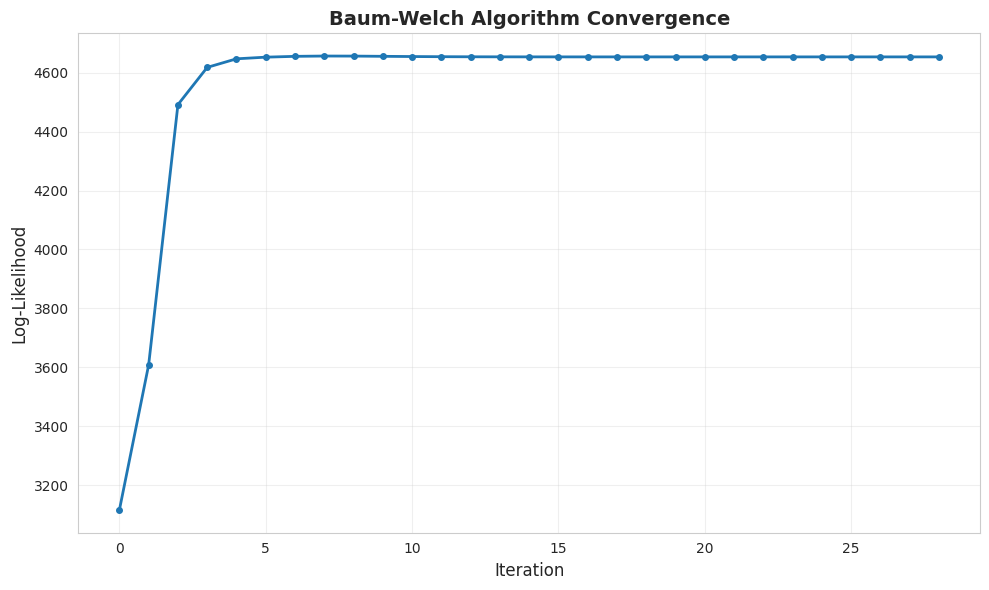


✅ Training complete!


In [36]:
print("\n" + "="*70)
print("STEP 8: MODEL TRAINING")
print("="*70)

n_states = 4  # walking, standing, jumping, still
n_features = X_train_scaled.shape[1]

# Initialize HMM
hmm_model = GaussianHMM(n_states, n_features)

# Initialize means with k-means-like approach (better than random)
print("\n🎲 Initializing model parameters...")
for i in range(n_states):
    mask = y_train == i
    if np.sum(mask) > 0:
        hmm_model.means_[i] = np.mean(X_train_scaled[mask], axis=0)
        hmm_model.covars_[i] = np.cov(X_train_scaled[mask].T) + np.eye(n_features) * 0.01

print("✅ Initialized with training data statistics")
print(f"   States: {n_states}")
print(f"   Features: {n_features}")

# Train model
hmm_model, log_likelihoods = baum_welch(hmm_model, X_train_scaled, max_iter=100, tol=1e-4)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods, marker='o', markersize=4, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.title('Baum-Welch Algorithm Convergence', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('convergence_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training complete!")

# Visualize Transition and Emission Probabilities


STEP 9: MODEL PARAMETER VISUALIZATION


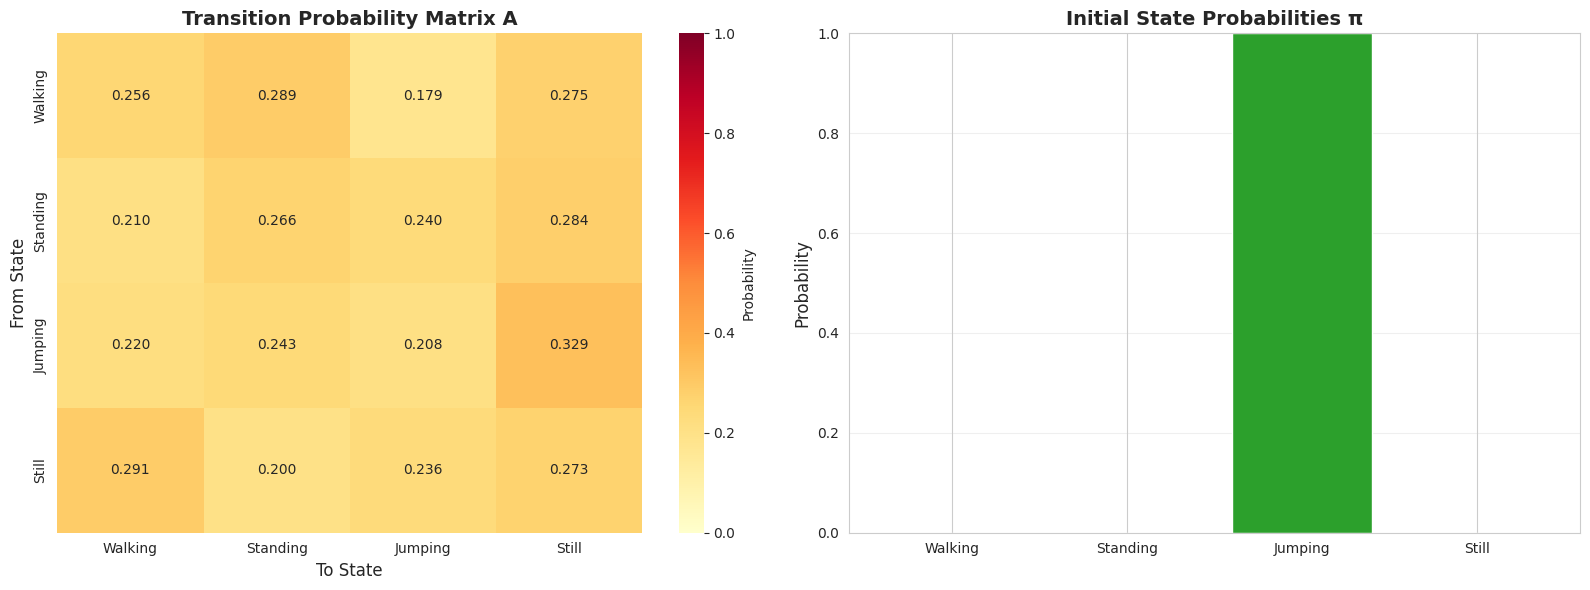


📊 Transition Matrix Analysis:
   Diagonal values (self-transitions):
   Walking     : 0.256 (stay in same state)
   Standing    : 0.266 (stay in same state)
   Jumping     : 0.208 (stay in same state)
   Still       : 0.273 (stay in same state)


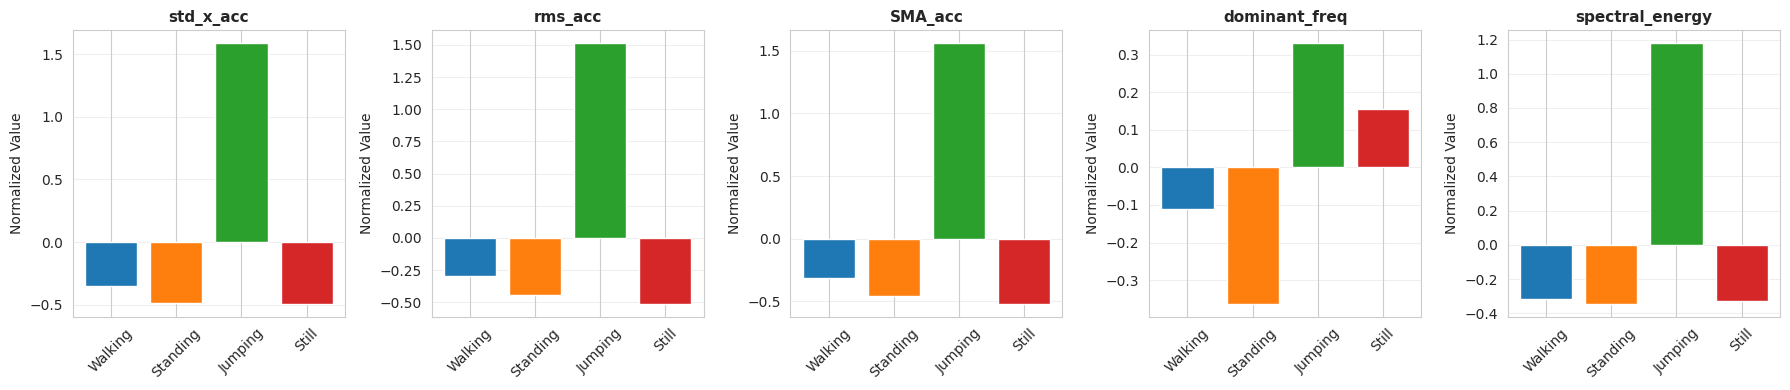


✅ Model parameters visualized


In [37]:
print("\n" + "="*70)
print("STEP 9: MODEL PARAMETER VISUALIZATION")
print("="*70)

activity_labels = ['Walking', 'Standing', 'Jumping', 'Still']

# Transition Matrix Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Transition probabilities
sns.heatmap(hmm_model.transmat_, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=activity_labels, yticklabels=activity_labels,
            cbar_kws={'label': 'Probability'}, ax=axes[0], vmin=0, vmax=1)
axes[0].set_title('Transition Probability Matrix A', fontsize=14, fontweight='bold')
axes[0].set_ylabel('From State', fontsize=12)
axes[0].set_xlabel('To State', fontsize=12)

# Initial state probabilities
axes[1].bar(activity_labels, hmm_model.startprob_, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('Initial State Probabilities π', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('transition_emission_probs.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Transition Matrix Analysis:")
print("   Diagonal values (self-transitions):")
for i, activity in enumerate(activity_labels):
    print(f"   {activity:<12}: {hmm_model.transmat_[i, i]:.3f} (stay in same state)")

# Visualize emission means for key features
feature_names = list(X_train.columns)
key_features = ['std_x_acc', 'rms_acc', 'SMA_acc', 'dominant_freq', 'spectral_energy']
feature_indices = [feature_names.index(f) for f in key_features if f in feature_names]

fig, axes = plt.subplots(1, len(feature_indices), figsize=(18, 4))
for idx, feat_idx in enumerate(feature_indices):
    feat_name = feature_names[feat_idx]
    axes[idx].bar(activity_labels, hmm_model.means_[:, feat_idx],
                  color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[idx].set_title(feat_name, fontsize=11, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_ylabel('Normalized Value', fontsize=10)

plt.tight_layout()
plt.savefig('emission_means_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Model parameters visualized")

 # Evaluate on Test Set


STEP 10: MODEL EVALUATION ON TEST SET

🔍 Decoding test sequences with Viterbi algorithm...

✅ Prediction complete
   Overall Accuracy: 0.9009 (90.09%)

PER-ACTIVITY PERFORMANCE METRICS

Walking:
   Samples: 27
   Sensitivity (Recall): 1.0000
   Specificity: 1.0000

Standing:
   Samples: 31
   Sensitivity (Recall): 0.8065
   Specificity: 0.9625

Jumping:
   Samples: 27
   Sensitivity (Recall): 0.8148
   Specificity: 1.0000

Still:
   Samples: 26
   Sensitivity (Recall): 1.0000
   Specificity: 0.9059

EVALUATION RESULTS TABLE
State (Activity)  Number of Samples Sensitivity Specificity Overall Accuracy
         Walking                 27      1.0000      1.0000           0.9009
        Standing                 31      0.8065      0.9625           0.9009
         Jumping                 27      0.8148      1.0000           0.9009
           Still                 26      1.0000      0.9059           0.9009


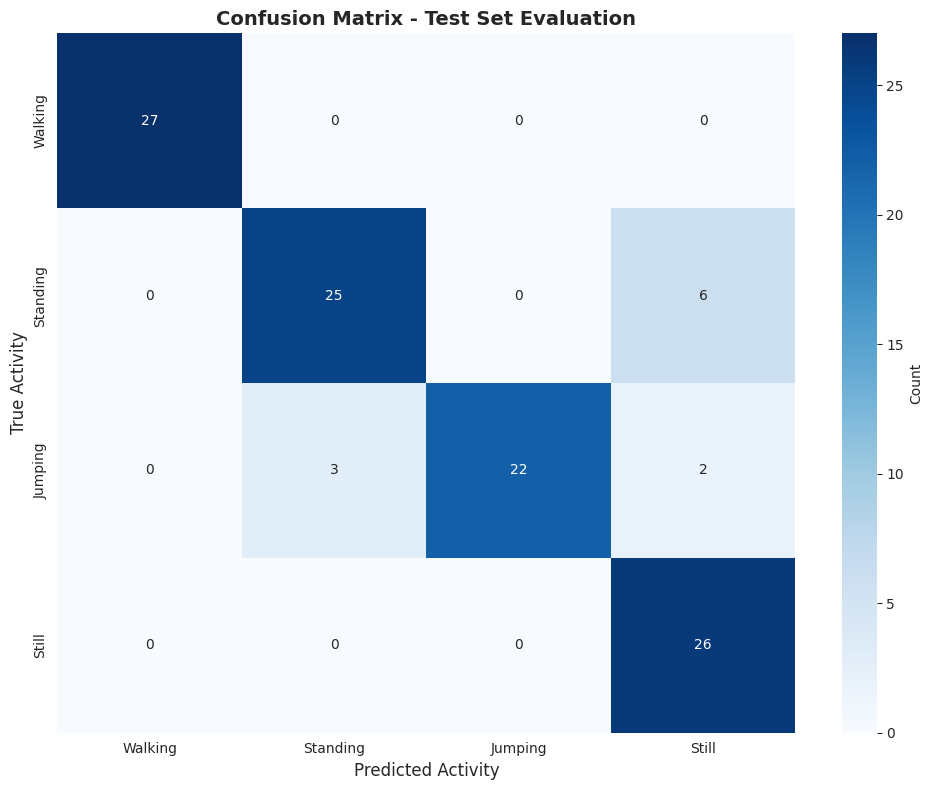


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Walking     1.0000    1.0000    1.0000        27
    Standing     0.8929    0.8065    0.8475        31
     Jumping     1.0000    0.8148    0.8980        27
       Still     0.7647    1.0000    0.8667        26

    accuracy                         0.9009       111
   macro avg     0.9144    0.9053    0.9030       111
weighted avg     0.9150    0.9009    0.9013       111



In [38]:
print("\n" + "="*70)
print("STEP 10: MODEL EVALUATION ON TEST SET")
print("="*70)

# Predict on test set
print("\n🔍 Decoding test sequences with Viterbi algorithm...")
y_pred, viterbi_prob = hmm_model.viterbi(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\n✅ Prediction complete")
print(f"   Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Calculate per-class metrics
print("\n" + "="*70)
print("PER-ACTIVITY PERFORMANCE METRICS")
print("="*70)

results_table = []
for i, activity in enumerate(activity_labels):
    tp = conf_matrix[i, i]
    fn = np.sum(conf_matrix[i, :]) - tp
    fp = np.sum(conf_matrix[:, i]) - tp
    tn = np.sum(conf_matrix) - tp - fn - fp

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    n_samples = np.sum(conf_matrix[i, :])

    results_table.append({
        'State (Activity)': activity,
        'Number of Samples': n_samples,
        'Sensitivity': f"{sensitivity:.4f}",
        'Specificity': f"{specificity:.4f}",
        'Overall Accuracy': f"{accuracy:.4f}"
    })

    print(f"\n{activity}:")
    print(f"   Samples: {n_samples}")
    print(f"   Sensitivity (Recall): {sensitivity:.4f}")
    print(f"   Specificity: {specificity:.4f}")

results_df = pd.DataFrame(results_table)
print("\n" + "="*70)
print("EVALUATION RESULTS TABLE")
print("="*70)
print(results_df.to_string(index=False))

# Confusion Matrix Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set Evaluation', fontsize=14, fontweight='bold')
plt.ylabel('True Activity', fontsize=12)
plt.xlabel('Predicted Activity', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Detailed classification report
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred, target_names=activity_labels, digits=4))